# Business Understanding 

## No perfect vacations? 
The online hotel reservation channels have dramatically changed booking possibilities and customers’ behavior. A significant number of hotel reservations are called-off due to cancellations or no-shows. The typical reasons for cancellations include change of plans, scheduling conflicts, etc. This is often made easier by the option to do so free of charge or preferably at a low cost which is beneficial to hotel guests but it is a less desirable and possibly revenue-diminishing factor for hotels to deal with.

## Goals
So the goals of this project is (1) explore data to find insights about cancelations, and (2) to build a machine learning model capable of predicting cancelations or no-shows beforehand. 

# Data Understanding

## The features

|**Feature**|**Description**|
|---|---|
|**Booking_ID**| Unique identifier of each booking|
|**no_of_adults**| Number of adults|
|**no_of_children**| Number of children|
|**no_of_weekend_nights**| Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel|
|**no_of_week_nights**| Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel|
|**type_of_meal_plan**| Type of meal plan booked by the customer|
|**required_car_parking_space**| Does the customer require a car parking space? (0 - No, 1 - Yes)|
|**room_type_reserved**| Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels|
|**lead_time**| Number of days between the date of booking and the arrival date|
|**arrival_year**| Year of arrival date|
|**arrival_month**| Month of arrival date|
|**arrival_date**| Date of the month|
|**market_segment_type**| Market segment designation|
|**repeated_guest**| Is the customer a repeated guest? (0 - No, 1 - Yes)|
|**no_of_previous_cancellations**| Number of previous bookings that were canceled by the customer prior to the current booking|
|**no_of_previous_bookings_not_canceled** | Number of previous bookings not canceled by the customer prior to the current booking|
|**avg_price_per_room**| Average price per day of the reservation; prices of the rooms are dynamic (in euros)|
|**no_of_special_requests**| Total number of special requests made by the customer (e.g. high floor, view from the room, etc)|
|**booking_status**| Flag indicating if the booking was canceled or not|


## Libraries import and loading the data

In [54]:
# Data manipulation
import pandas as pd
import numpy as np

# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from lightgbm import LGBMClassifier

# Pre-processing
import optuna
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from category_encoders import TargetEncoder, OrdinalEncoder

# Notebook config
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette('Dark2')
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv("../data/raw/Hotel Reservations.csv")

## Data quality 

In [3]:
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns.")

The dataset has 36275 rows and 19 columns.


In [4]:
print(f"The dataset has: {len(data.select_dtypes(include = 'object').columns.to_list())} categorical columns.")
print(f"The dataset has: {len(data.select_dtypes(include = 'number').columns.to_list())} numeric columns.")

The dataset has: 5 categorical columns.
The dataset has: 14 numeric columns.


In [5]:
data.nunique().sort_values()

arrival_year                                2
repeated_guest                              2
required_car_parking_space                  2
booking_status                              2
type_of_meal_plan                           4
market_segment_type                         5
no_of_adults                                5
no_of_children                              6
no_of_special_requests                      6
room_type_reserved                          7
no_of_weekend_nights                        8
no_of_previous_cancellations                9
arrival_month                              12
no_of_week_nights                          18
arrival_date                               31
no_of_previous_bookings_not_canceled       59
lead_time                                 352
avg_price_per_room                       3930
Booking_ID                              36275
dtype: int64

In [6]:
data.dtypes

Booking_ID                               object
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                        object
required_car_parking_space                int64
room_type_reserved                       object
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                      object
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                           object
dtype: object

In [7]:
data.isnull().mean()

Booking_ID                              0.0
no_of_adults                            0.0
no_of_children                          0.0
no_of_weekend_nights                    0.0
no_of_week_nights                       0.0
type_of_meal_plan                       0.0
required_car_parking_space              0.0
room_type_reserved                      0.0
lead_time                               0.0
arrival_year                            0.0
arrival_month                           0.0
arrival_date                            0.0
market_segment_type                     0.0
repeated_guest                          0.0
no_of_previous_cancellations            0.0
no_of_previous_bookings_not_canceled    0.0
avg_price_per_room                      0.0
no_of_special_requests                  0.0
booking_status                          0.0
dtype: float64

In [8]:
data.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


## Exploratory Data Analysis

In [9]:
data.describe().round(4).T

,count,mean,std,min,25%,50%,75%,max
no_of_adults,36275.0,1.8450,0.5187,0.0,2.0,2.00,2.0,4.0
no_of_children,36275.0,0.1053,0.4026,0.0,0.0,0.00,0.0,10.0
no_of_weekend_nights,36275.0,0.8107,0.8706,0.0,0.0,1.00,2.0,7.0
no_of_week_nights,36275.0,2.2043,1.4109,0.0,1.0,2.00,3.0,17.0
required_car_parking_space,36275.0,0.0310,0.1733,0.0,0.0,0.00,0.0,1.0
lead_time,36275.0,85.2326,85.9308,0.0,17.0,57.00,126.0,443.0
arrival_year,36275.0,2017.8204,0.3838,2017.0,2018.0,2018.00,2018.0,2018.0
arrival_month,36275.0,7.4237,3.0699,1.0,5.0,8.00,10.0,12.0
arrival_date,36275.0,15.5970,8.7404,1.0,8.0,16.00,23.0,31.0
repeated_guest,36275.0,0.0256,0.1581,0.0,0.0,0.00,0.0,1.0


In [10]:
data.select_dtypes(exclude = 'number').describe().T

,count,unique,top,freq
Booking_ID,36275,36275,INN00001,1
type_of_meal_plan,36275,4,Meal Plan 1,27835
room_type_reserved,36275,7,Room_Type 1,28130
market_segment_type,36275,5,Online,23214
booking_status,36275,2,Not_Canceled,24390


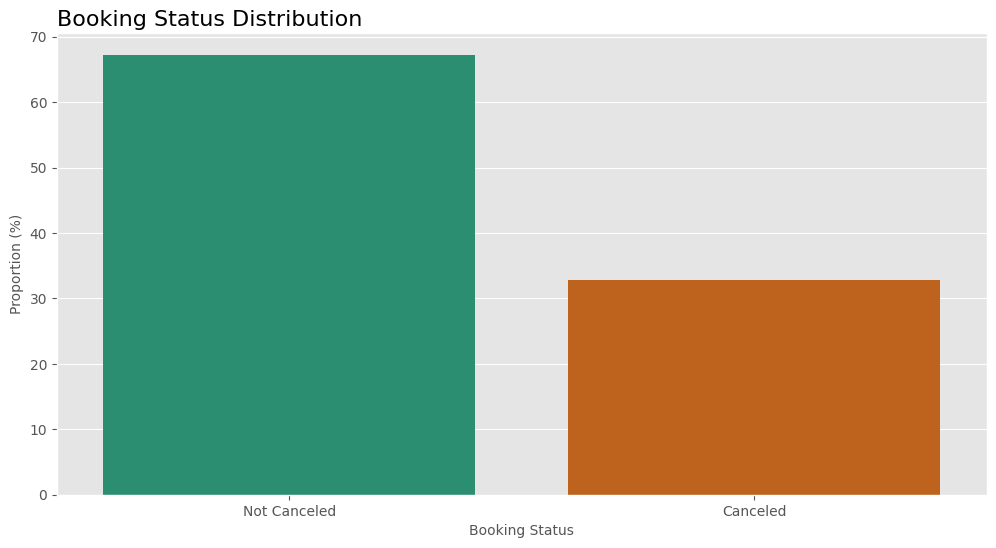

In [11]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(x = data['booking_status'], hue = data['booking_status'], stat = 'percent')
ax.set_title("Booking Status Distribution", fontsize = 16, pad = 5, loc = 'left')
ax.set_xlabel("Booking Status", fontsize = 10)
ax.set_ylabel("Proportion (%)", fontsize = 10)
ax.set_xticklabels(['Not Canceled', 'Canceled'])
plt.show()

### Lead time x Cancelations
Bookings made far in advance of the arrival date may have a higher probability of cancellation. Trips are always susceptible to changes in plans and unforeseen events, let's work on this hypothesis:

- $H_0:$ Lead time does not have a significant effect on cancellations.
- $H_1:$ A higher lead time increases the probability of cancellation.

In [12]:
from scipy.stats import mannwhitneyu

group_a = data[data['booking_status'] == 'Canceled']['lead_time']
group_b = data[data['booking_status'] == 'Not_Canceled']['lead_time']

_, p_value = mannwhitneyu(group_a, group_b, alternative = 'greater')

alpha = 0.05

if p_value < alpha:
    print("Reject H0: A higher lead time increases the probability of cancellation.")
else:
    print("We do not reject H0: Lead time does not have a significant effect on cancellations.")

Reject H0: A higher lead time increases the probability of cancellation.


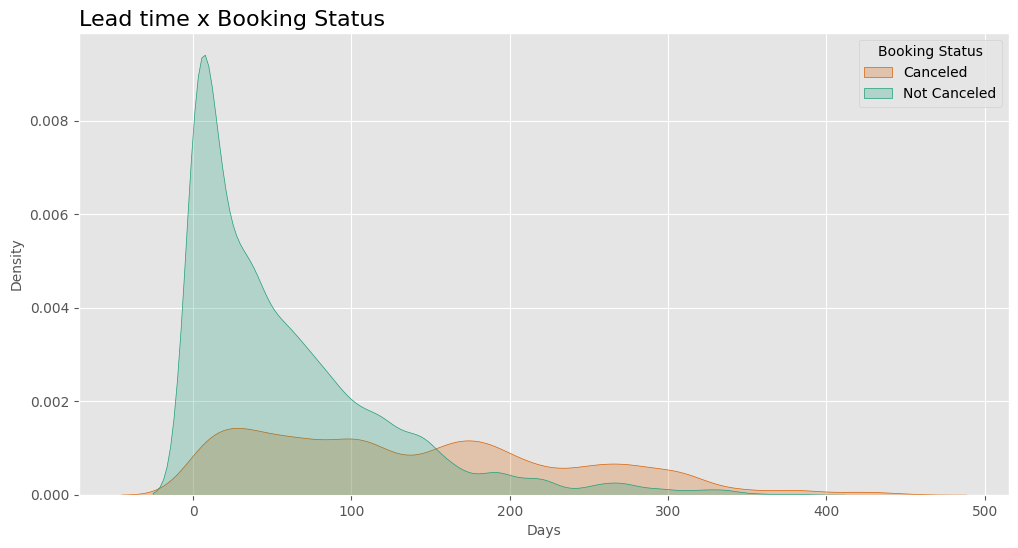

In [13]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.kdeplot(x = data['lead_time'], hue = data['booking_status'], fill = True)
ax.set_title("Lead time x Booking Status", fontsize = 16, pad = 5, loc = 'left')
ax.set_xlabel("Days", fontsize = 10)
ax.set_ylabel("Density", fontsize = 10)
ax.legend(title = 'Booking Status', labels = ['Canceled', 'Not Canceled'])
plt.show()

Bookings made between 150 and 300 days in advance have a higher probability of cancellation. It is advisable to create alerts and reservation confirmations starting from the 100-day mark.

### Average Price per Room x Cancelations
Does a higher priced room have higher probability of cancellation?
- $H_0:$ The average price per room has no significant effect on the probability of cancellations.
- $H_1:$ A higher average price per room is associated with a higher probability of cancellations.

In [14]:
group_a = data[data['booking_status'] == 'Canceled']['avg_price_per_room']
group_b = data[data['booking_status'] == 'Not_Canceled']['avg_price_per_room']

_, p_value = mannwhitneyu(group_a, group_b, alternative = 'greater')

alpha = 0.05

if p_value < alpha:
    print("Reject H0: A higher average price per room is associated with a higher probability of cancellations.")
else:
    print("We do not reject H0: The average price per room has no significant effect on the probability of cancellations.")

Reject H0: A higher average price per room is associated with a higher probability of cancellations.


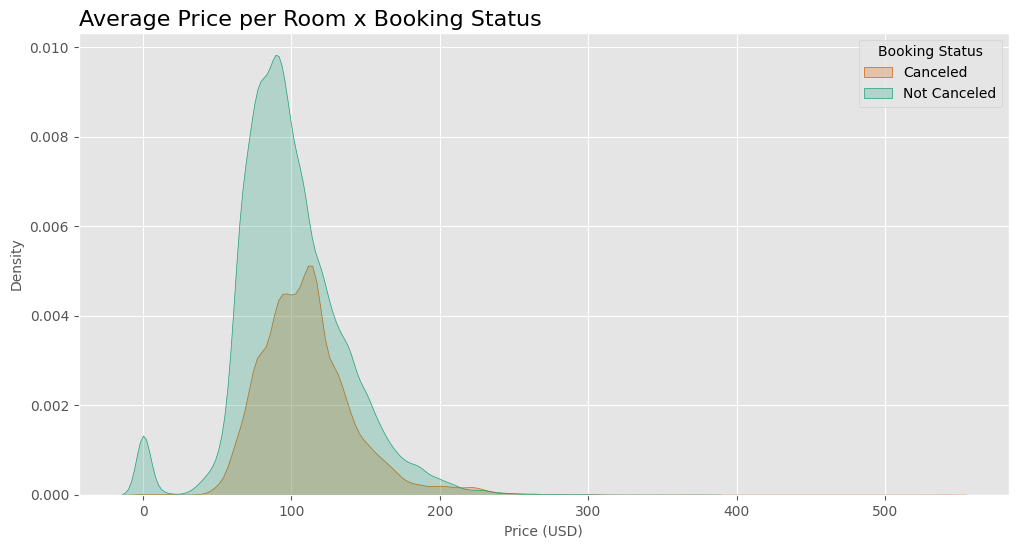

In [15]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.kdeplot(x = data['avg_price_per_room'], hue = data['booking_status'], fill = True)
ax.set_title("Average Price per Room x Booking Status", fontsize = 16, pad = 5, loc = 'left')
ax.set_xlabel("Price (USD)", fontsize = 10)
ax.set_ylabel("Density", fontsize = 10)
ax.legend(title = 'Booking Status', labels = ['Canceled', 'Not Canceled'])
plt.show()

### Number of Children x Cancelations
A higher number of children makes travel planning more difficult, as children tend to get sick more often, among other possible unforeseen events.

- $H_0:$ Number of children not have a significant effect on cancellations.
- $H_1:$ A higher number of children increases the probability of cancellation.

In [16]:
group_a = data[data['booking_status'] == 'Canceled']['no_of_children']
group_b = data[data['booking_status'] == 'Not_Canceled']['no_of_children']

_, p_value = mannwhitneyu(group_a, group_b, alternative = 'greater')

alpha = 0.05

if p_value < alpha:
    print("Reject H0: A higher number of children increases the probability of cancellation.")
else:
    print("We do not reject H0: number of children does not have a significant effect on cancellations.")

Reject H0: A higher number of children increases the probability of cancellation.


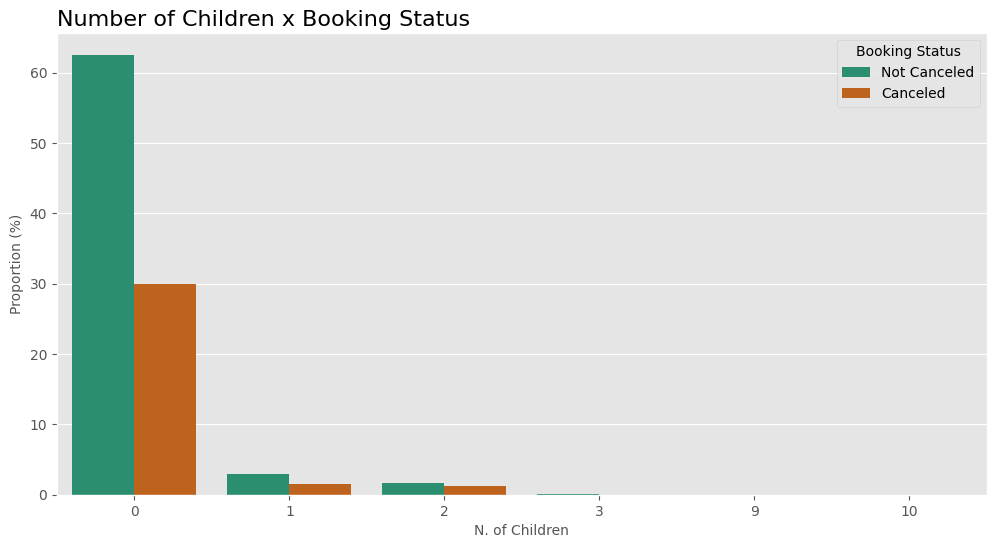

In [17]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.countplot(x = data['no_of_children'], hue = data['booking_status'], stat = 'percent')
ax.set_title("Number of Children x Booking Status", fontsize = 16, pad = 5, loc = 'left')
ax.set_xlabel("N. of Children", fontsize = 10)
ax.set_ylabel("Proportion (%)", fontsize = 10)
ax.legend(title = 'Booking Status', labels = ['Not Canceled', 'Canceled'])
plt.show()

### Room Type x Cancelation
The room type may also be related to cancellations, let's investigate this.

- $H_0:$ Room Type is independent of Booking Status.
- $H_1:$ Room Type is not independent of Booking Status.

In [18]:
from scipy.stats import chi2_contingency

contigency_table = pd.crosstab(data['room_type_reserved'], data['booking_status'])
chi2, p_value, dof, expected = chi2_contingency(contigency_table)

alpha = 0.05
if p_value < alpha:
    print("Reject H0: Room Type and Booking Status are related.")
else:
    print("We do not reject H0: : There is not enough evidence to assert that Room Type and Booking Status are related.")

Reject H0: Room Type and Booking Status are related.


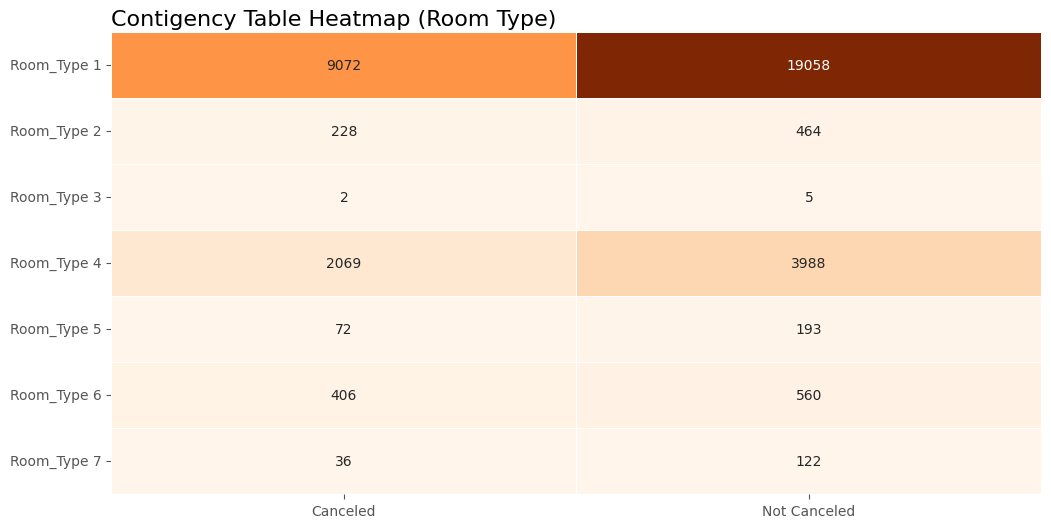

In [19]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.heatmap(contigency_table, annot = True, linewidths=.5, fmt = 'd', cmap = 'Oranges', cbar=False)
ax.set_title("Contigency Table Heatmap (Room Type)", fontsize = 16, pad = 5, loc = 'left')
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels(['Canceled', 'Not Canceled'])
plt.show()

- Room Type 1 is the most popular.
- Room Type 3 is the least popular.
- Room Type 6 has the highest cancelation rate. 

As we can see, Room Type and the Booking Status are related. 

### Market Segment x Booking Status

- $H_0:$ Market Segment is independent of Booking Status.
- $H_1:$ Market Segment is not independent of Booking Status

In [20]:
contigency_table_2 = pd.crosstab(data['market_segment_type'], data['booking_status'])
chi2, p_value, dof, expected = chi2_contingency(contigency_table_2)

alpha = 0.05
if p_value < alpha:
    print("Reject H0: Marketing Segment and Booking Status are related.")
else:
    print("We do not reject H0: : There is not enough evidence to assert that Marketing Segment and Booking Status are related.")

Reject H0: Marketing Segment and Booking Status are related.


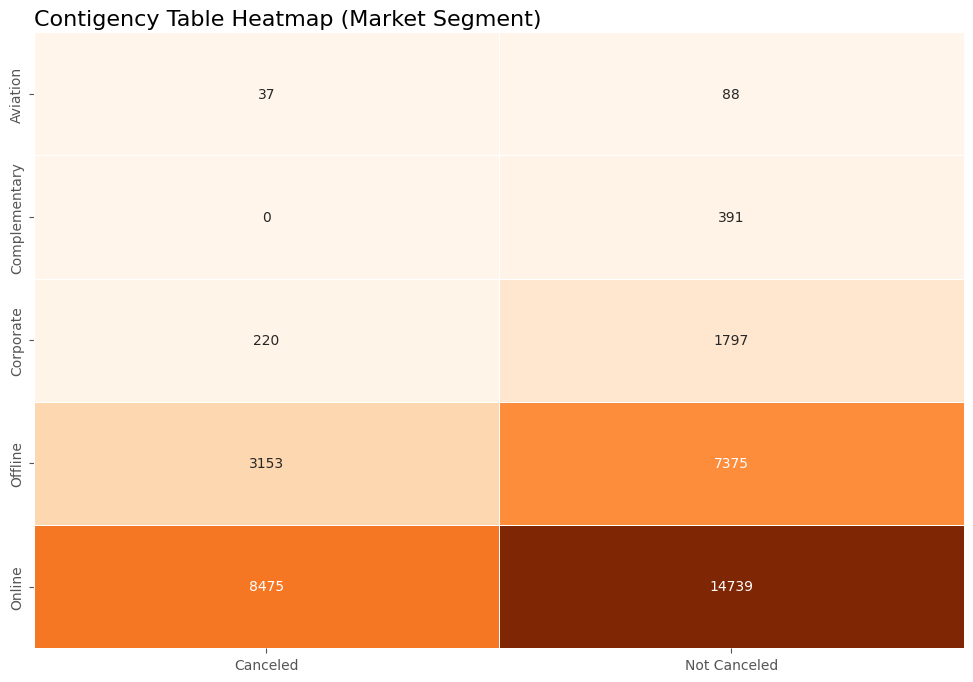

In [21]:
fig, ax = plt.subplots(figsize = (12, 8))

sns.heatmap(contigency_table_2, annot = True, linewidths=.5, fmt = 'd', cmap = 'Oranges', cbar=False)
ax.set_title("Contigency Table Heatmap (Market Segment)", fontsize = 16, pad = 5, loc = 'left')
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels(['Canceled', 'Not Canceled'])
plt.show()

- Online segment is the most popular and also has the highest cancellation rate;
- Complementary segment has 0 cancellations;
- Corporate also has a low cancellation rate. 

### Correlation Matrix

In [22]:
dummies = data.drop(columns = 'Booking_ID', axis = 1).copy()
dummies = pd.get_dummies(dummies, prefix = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type','booking_status'], dtype = int)
corr = dummies.corr()

In [23]:
corr.loc['booking_status_Canceled'].sort_values(ascending = False)

booking_status_Canceled                 1.000000
lead_time                               0.438538
arrival_year                            0.179529
avg_price_per_room                      0.142569
market_segment_type_Online              0.106362
no_of_week_nights                       0.092996
no_of_adults                            0.086920
type_of_meal_plan_Meal Plan 2           0.086370
no_of_weekend_nights                    0.061563
no_of_children                          0.033078
room_type_reserved_Room_Type 6          0.032652
room_type_reserved_Room_Type 4          0.013309
arrival_date                            0.010629
type_of_meal_plan_Not Selected          0.003072
room_type_reserved_Room_Type 2          0.000548
room_type_reserved_Room_Type 3         -0.001241
type_of_meal_plan_Meal Plan 3          -0.003193
market_segment_type_Aviation           -0.003964
room_type_reserved_Room_Type 5         -0.010224
arrival_month                          -0.011233
room_type_reserved_R

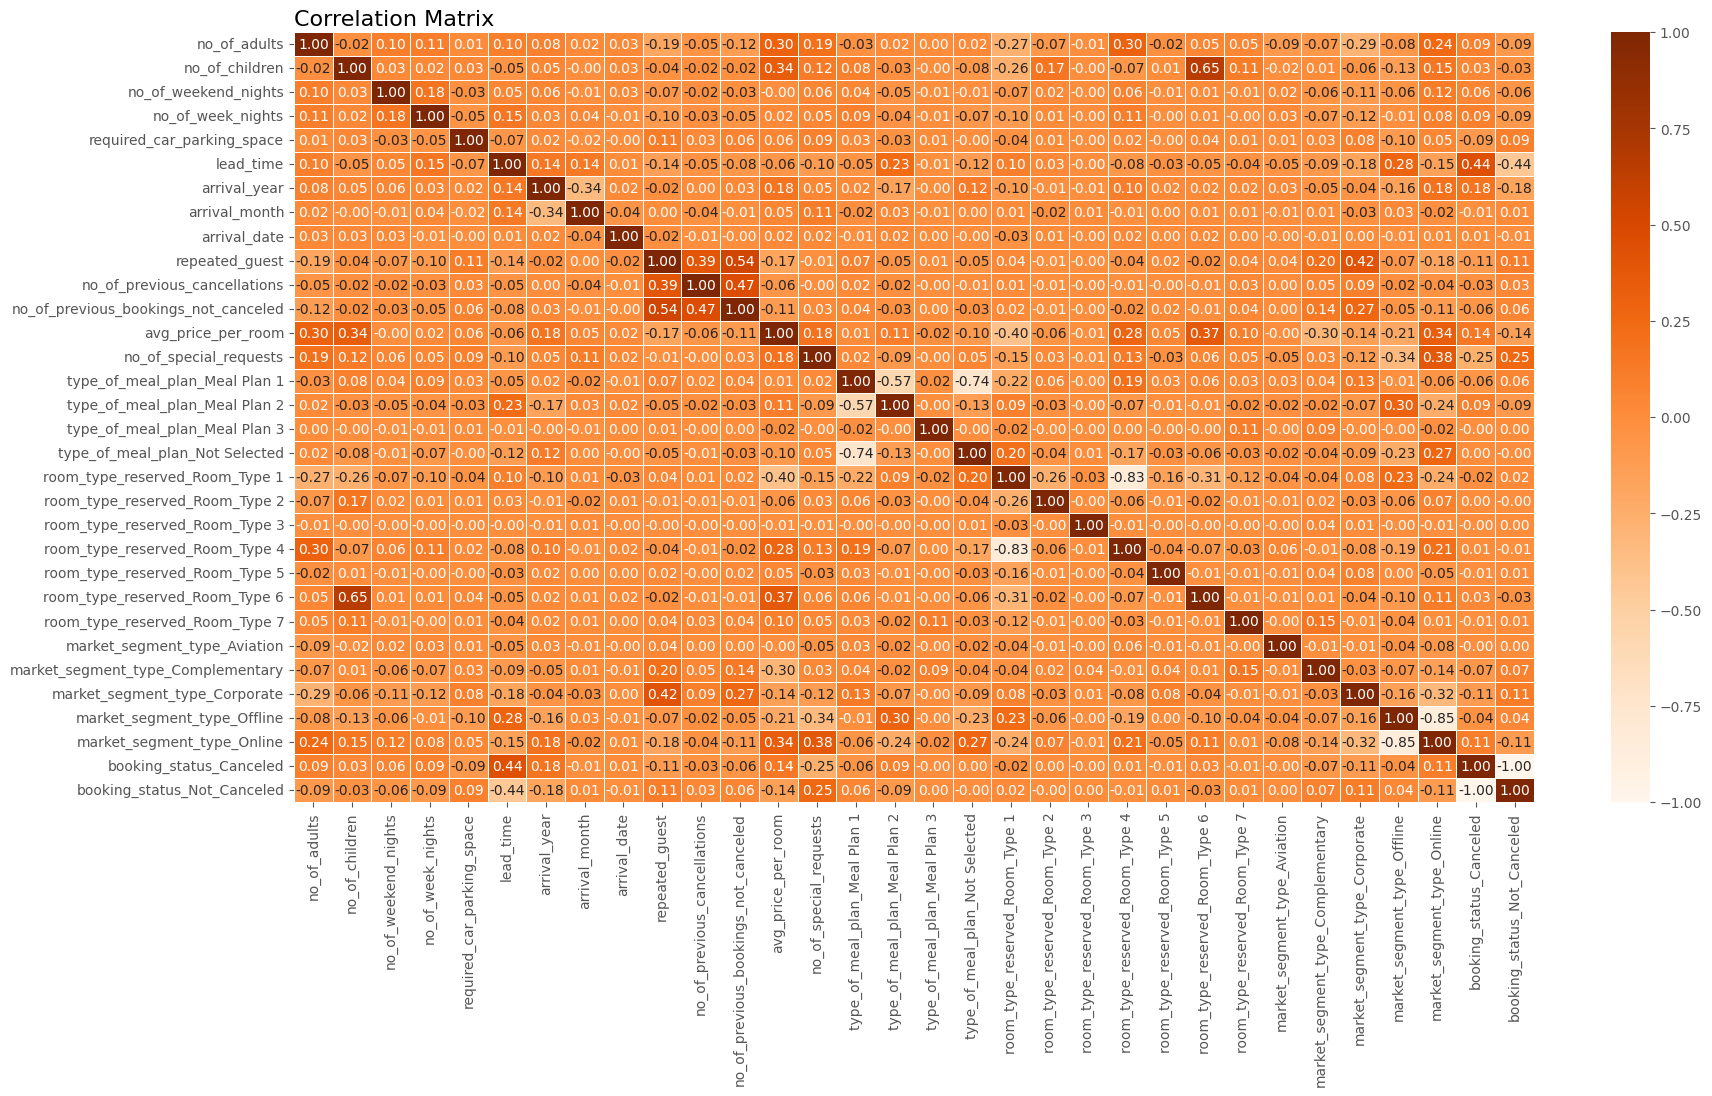

In [24]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(corr, annot = True, fmt = '.2f', linewidths=.5, cmap = 'Oranges')
ax.set_title("Correlation Matrix",fontsize = 16, pad = 5, loc = 'left')
plt.show()

# Data Preparation

## Data manipulation

In [25]:
# Lets change the flag to int dtype

data['booking_status'] = data['booking_status'].map({'Canceled': 1, 'Not_Canceled': 0})

In [26]:
# We will drop the Booking_ID column and also the arrival_year. I believe month e day columns may catch sazonality trends. 

df = data.drop(columns = ['Booking_ID', 'arrival_year'], axis = 1).copy()

## Pre-processing

In [27]:
features = df.drop(columns = 'booking_status', axis = 1).columns.to_list()
target = 'booking_status'

X = df[features]
y = df[target]

In [28]:
cat_features = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'repeated_guest', 'required_car_parking_space']
num_features = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']
ordinal_features = ['arrival_date', 'arrival_month']

In [29]:
cat_transformer = Pipeline([
    ('imput_cat', CategoricalImputer(imputation_method='frequent')),
    ('encoder_cat', TargetEncoder())
])

num_transformer = Pipeline([
    ('imput_num', MeanMedianImputer(imputation_method='median'))
])

ordinal_transformer = Pipeline([
    ('imput_or', MeanMedianImputer(imputation_method='median')),
    ('encoder_or', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features),
        ('ordinal', ordinal_transformer, ordinal_features)
    ]
)

# Modeling

In [30]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=21)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.25, random_state=21)

## Base model

In [31]:
model = LGBMClassifier(random_state=21)

base_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])

base_clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 7163, number of negative: 14602
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 21765, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.329106 -> initscore=-0.712230
[LightGBM] [Info] Start training from score -0.712230


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imput_cat',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('encoder_cat',
                                                                   TargetEncoder())]),
                                                  ['type_of_meal_plan',
                                                   'room_type_reserved',
                                                   'market_segment_type',
                                                   'repeated_guest',
                                                   'required_car_parking_space']),
                                                 ('num',
                                                  Pipeline(steps=[('imput_num',
                                                                   MeanMedianImputer(...
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'lead_time',
                                                   'no_of_previous_cancellations',
                                                   'no_of_previous_bookings_not_canceled',
                                                   'avg_price_per_room',
                                                   'no_of_special_requests']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imput_or',
                                                                   MeanMedianImputer()),
                                                                  ('encoder_or',
                                                                   OrdinalEncoder())]),
                                                  ['arrival_date',
                                                   'arrival_month'])])),
                ('classifier', LGBMClassifier(random_state=21))])

In [32]:
y_proba_base = base_clf.predict_proba(X_val)[:,1]
y_pred_base = (y_proba_base > 0.5).astype(int)

In [33]:
print(f"Validation Set - Results\n{'-'*25}")
print(f"Accuracy: {metrics.accuracy_score(y_val, y_pred_base):.4f}")
print(f"F1 Score: {metrics.f1_score(y_val, y_pred_base):.4f}")
print(f"ROC AUC: {metrics.roc_auc_score(y_val, y_proba_base):.4f}")

Validation Set - Results
-------------------------
Accuracy: 0.8815
F1 Score: 0.8111
ROC AUC: 0.9427


In [34]:
print(f"{"="*15} Classification Report {"="*15}\n")
print(metrics.classification_report(y_val, y_pred_base))

=============== Classification Report ===============

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4854
           1       0.86      0.77      0.81      2401

    accuracy                           0.88      7255
   macro avg       0.87      0.85      0.86      7255
weighted avg       0.88      0.88      0.88      7255



In pursuit of balance and better results we will optimize our model around the F1 Score.

## Optimized model

In [35]:
def objective(trial):
    model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        verbosity = -1,
        n_estimators = 1000,
        learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        num_leaves = trial.suggest_int("num_leaves", 2, 2**10),
        subsample = trial.suggest_float("subsample", 0.05, 1.0),
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.05, 1.0),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1, 100),
        random_state = 21
    ))
    ])

    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    f1score = metrics.f1_score(y_val, predictions)
    return f1score

In [36]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-08-28 19:07:27,017] A new study created in memory with name: no-name-aba68665-add1-4220-8b18-be41fa816d11


[I 2024-08-28 19:07:33,767] Trial 0 finished with value: 0.780917929007461 and parameters: {'learning_rate': 0.01575481934825425, 'num_leaves': 693, 'subsample': 0.07257609479264933, 'colsample_bytree': 0.17125373138867628, 'min_data_in_leaf': 45}. Best is trial 0 with value: 0.780917929007461.


[I 2024-08-28 19:07:42,222] Trial 1 finished with value: 0.6798418972332015 and parameters: {'learning_rate': 0.0019020911441208846, 'num_leaves': 694, 'subsample': 0.3050646418200134, 'colsample_bytree': 0.357559819519452, 'min_data_in_leaf': 77}. Best is trial 0 with value: 0.780917929007461.


[I 2024-08-28 19:07:52,902] Trial 2 finished with value: 0.8106043585711076 and parameters: {'learning_rate': 0.00417997101589838, 'num_leaves': 264, 'subsample': 0.903619087320658, 'colsample_bytree': 0.5527726641354044, 'min_data_in_leaf': 38}. Best is trial 2 with value: 0.8106043585711076.


[I 2024-08-28 19:08:03,012] Trial 3 finished with value: 0.1109362706530291 and parameters: {'learning_rate': 0.0014093559259069194, 'num_leaves': 434, 'subsample': 0.6025834173481727, 'colsample_bytree': 0.09841881011624212, 'min_data_in_leaf': 8}. Best is trial 2 with value: 0.8106043585711076.


[I 2024-08-28 19:08:06,048] Trial 4 finished with value: 0.8253208614313683 and parameters: {'learning_rate': 0.026133115786975702, 'num_leaves': 45, 'subsample': 0.3963810355072208, 'colsample_bytree': 0.6399645675048041, 'min_data_in_leaf': 25}. Best is trial 4 with value: 0.8253208614313683.


[I 2024-08-28 19:08:13,874] Trial 5 finished with value: 0.74645129711209 and parameters: {'learning_rate': 0.002246205011822298, 'num_leaves': 400, 'subsample': 0.6974639676180155, 'colsample_bytree': 0.42441623484664925, 'min_data_in_leaf': 86}. Best is trial 4 with value: 0.8253208614313683.


[I 2024-08-28 19:08:30,775] Trial 6 finished with value: 0.7797177708682134 and parameters: {'learning_rate': 0.0016793179828671248, 'num_leaves': 792, 'subsample': 0.9954077702592083, 'colsample_bytree': 0.6217547791545509, 'min_data_in_leaf': 35}. Best is trial 4 with value: 0.8253208614313683.


[I 2024-08-28 19:08:38,083] Trial 7 finished with value: 0.7997308813635344 and parameters: {'learning_rate': 0.010360282422196953, 'num_leaves': 573, 'subsample': 0.5083713046715959, 'colsample_bytree': 0.31037251024163015, 'min_data_in_leaf': 80}. Best is trial 4 with value: 0.8253208614313683.


[I 2024-08-28 19:08:52,149] Trial 8 finished with value: 0.7175375064666322 and parameters: {'learning_rate': 0.0010248832698531638, 'num_leaves': 866, 'subsample': 0.5769135461206005, 'colsample_bytree': 0.5988747669613056, 'min_data_in_leaf': 46}. Best is trial 4 with value: 0.8253208614313683.


[I 2024-08-28 19:09:09,791] Trial 9 finished with value: 0.8353378526131642 and parameters: {'learning_rate': 0.02331572881172912, 'num_leaves': 497, 'subsample': 0.7527103411997251, 'colsample_bytree': 0.7094172373716079, 'min_data_in_leaf': 21}. Best is trial 9 with value: 0.8353378526131642.


[I 2024-08-28 19:09:30,957] Trial 10 finished with value: 0.8350583571900463 and parameters: {'learning_rate': 0.07236371629528207, 'num_leaves': 1017, 'subsample': 0.8039120859624059, 'colsample_bytree': 0.9235415040873682, 'min_data_in_leaf': 1}. Best is trial 9 with value: 0.8353378526131642.


[I 2024-08-28 19:09:52,764] Trial 11 finished with value: 0.8369947275922671 and parameters: {'learning_rate': 0.06870145636595233, 'num_leaves': 997, 'subsample': 0.7862997832574106, 'colsample_bytree': 0.9347307739548064, 'min_data_in_leaf': 2}. Best is trial 11 with value: 0.8369947275922671.


[I 2024-08-28 19:10:02,078] Trial 12 finished with value: 0.8320944468736335 and parameters: {'learning_rate': 0.06965497395540485, 'num_leaves': 254, 'subsample': 0.8044826565417111, 'colsample_bytree': 0.9323368611352647, 'min_data_in_leaf': 17}. Best is trial 11 with value: 0.8369947275922671.


[I 2024-08-28 19:10:21,536] Trial 13 finished with value: 0.8332968236582694 and parameters: {'learning_rate': 0.03388057946718012, 'num_leaves': 563, 'subsample': 0.7467898498473614, 'colsample_bytree': 0.7820749504543442, 'min_data_in_leaf': 16}. Best is trial 11 with value: 0.8369947275922671.


[I 2024-08-28 19:10:34,014] Trial 14 finished with value: 0.8326105810928014 and parameters: {'learning_rate': 0.03400848144017518, 'num_leaves': 1019, 'subsample': 0.9366177052029995, 'colsample_bytree': 0.7762377249892383, 'min_data_in_leaf': 62}. Best is trial 11 with value: 0.8369947275922671.


[I 2024-08-28 19:10:44,418] Trial 15 finished with value: 0.8336970755128764 and parameters: {'learning_rate': 0.0711854874607767, 'num_leaves': 285, 'subsample': 0.6484383971849066, 'colsample_bytree': 0.7970522898684436, 'min_data_in_leaf': 22}. Best is trial 11 with value: 0.8369947275922671.


[I 2024-08-28 19:11:17,849] Trial 16 finished with value: 0.8359392204360273 and parameters: {'learning_rate': 0.0057547881485521535, 'num_leaves': 905, 'subsample': 0.8513299039068081, 'colsample_bytree': 0.8518738044870688, 'min_data_in_leaf': 1}. Best is trial 11 with value: 0.8369947275922671.


[I 2024-08-28 19:11:26,300] Trial 17 finished with value: 0.8138414367060884 and parameters: {'learning_rate': 0.005115963020062098, 'num_leaves': 901, 'subsample': 0.8816094583033557, 'colsample_bytree': 0.9791028516835338, 'min_data_in_leaf': 100}. Best is trial 11 with value: 0.8369947275922671.


[I 2024-08-28 19:11:38,365] Trial 18 finished with value: 0.8226018396846255 and parameters: {'learning_rate': 0.005634941979453718, 'num_leaves': 905, 'subsample': 0.36272372200044944, 'colsample_bytree': 0.8688692435154237, 'min_data_in_leaf': 60}. Best is trial 11 with value: 0.8369947275922671.


[I 2024-08-28 19:12:05,217] Trial 19 finished with value: 0.8343208251042352 and parameters: {'learning_rate': 0.010569089182296588, 'num_leaves': 744, 'subsample': 0.8378139502092883, 'colsample_bytree': 0.9989885763129266, 'min_data_in_leaf': 4}. Best is trial 11 with value: 0.8369947275922671.


[I 2024-08-28 19:12:35,348] Trial 20 finished with value: 0.8342105263157895 and parameters: {'learning_rate': 0.0038046939695369933, 'num_leaves': 894, 'subsample': 0.4914044002693227, 'colsample_bytree': 0.8554287829901227, 'min_data_in_leaf': 10}. Best is trial 11 with value: 0.8369947275922671.


[I 2024-08-28 19:12:55,418] Trial 21 finished with value: 0.8327153762268266 and parameters: {'learning_rate': 0.017067892448375963, 'num_leaves': 620, 'subsample': 0.740606410105164, 'colsample_bytree': 0.692806049214498, 'min_data_in_leaf': 28}. Best is trial 11 with value: 0.8369947275922671.


[I 2024-08-28 19:13:09,960] Trial 22 finished with value: 0.8349769888231426 and parameters: {'learning_rate': 0.0395887904629496, 'num_leaves': 416, 'subsample': 0.6857375367321686, 'colsample_bytree': 0.7267485654384901, 'min_data_in_leaf': 11}. Best is trial 11 with value: 0.8369947275922671.


[I 2024-08-28 19:13:26,397] Trial 23 finished with value: 0.8358143607705779 and parameters: {'learning_rate': 0.09546613210785125, 'num_leaves': 815, 'subsample': 0.9650988537449217, 'colsample_bytree': 0.8565370650086939, 'min_data_in_leaf': 1}. Best is trial 11 with value: 0.8369947275922671.


[I 2024-08-28 19:13:43,902] Trial 24 finished with value: 0.8334433443344335 and parameters: {'learning_rate': 0.09167439419034766, 'num_leaves': 968, 'subsample': 0.9932367520659421, 'colsample_bytree': 0.8722914012228362, 'min_data_in_leaf': 1}. Best is trial 11 with value: 0.8369947275922671.


[I 2024-08-28 19:14:09,922] Trial 25 finished with value: 0.8278742580786986 and parameters: {'learning_rate': 0.04947635285294934, 'num_leaves': 815, 'subsample': 0.8927404943074675, 'colsample_bytree': 0.5124175912309769, 'min_data_in_leaf': 12}. Best is trial 11 with value: 0.8369947275922671.


[I 2024-08-28 19:14:46,997] Trial 26 finished with value: 0.8360908890359585 and parameters: {'learning_rate': 0.007301541653621315, 'num_leaves': 960, 'subsample': 0.8438933557474755, 'colsample_bytree': 0.8354528355029329, 'min_data_in_leaf': 1}. Best is trial 11 with value: 0.8369947275922671.


[I 2024-08-28 19:15:04,970] Trial 27 finished with value: 0.8316270964931387 and parameters: {'learning_rate': 0.0074723146884285085, 'num_leaves': 948, 'subsample': 0.8533932837644331, 'colsample_bytree': 0.9342100440971319, 'min_data_in_leaf': 37}. Best is trial 11 with value: 0.8369947275922671.


[I 2024-08-28 19:15:28,042] Trial 28 finished with value: 0.8185448092280391 and parameters: {'learning_rate': 0.0030149786777874076, 'num_leaves': 1020, 'subsample': 0.18347985925573962, 'colsample_bytree': 0.8028469948382004, 'min_data_in_leaf': 29}. Best is trial 11 with value: 0.8369947275922671.


[I 2024-08-28 19:15:34,402] Trial 29 finished with value: 0.7760785208856426 and parameters: {'learning_rate': 0.013604830616288404, 'num_leaves': 704, 'subsample': 0.7876599624848081, 'colsample_bytree': 0.206640688757194, 'min_data_in_leaf': 56}. Best is trial 11 with value: 0.8369947275922671.


In [37]:
print(f"Best hyperparameters: {study.best_params}")
print(f"Best F1 Score: {study.best_value}")

Best hyperparameters: {'learning_rate': 0.06870145636595233, 'num_leaves': 997, 'subsample': 0.7862997832574106, 'colsample_bytree': 0.9347307739548064, 'min_data_in_leaf': 2}
Best F1 Score: 0.8369947275922671


In [74]:
param_dict = {'learning_rate': 0.06870145636595233, 'num_leaves': 997, 'subsample': 0.7862997832574106, 'colsample_bytree': 0.9347307739548064, 'min_data_in_leaf': 2}
param_dict

{'learning_rate': 0.06870145636595233,
 'num_leaves': 997,
 'subsample': 0.7862997832574106,
 'colsample_bytree': 0.9347307739548064,
 'min_data_in_leaf': 2}

In [44]:
model = LGBMClassifier(**param_dict, n_estimators=1000, random_state=21)

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imput_cat',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('encoder_cat',
                                                                   TargetEncoder())]),
                                                  ['type_of_meal_plan',
                                                   'room_type_reserved',
                                                   'market_segment_type',
                                                   'repeated_guest',
                                                   'required_car_parking_space']),
                                                 ('num',
                                                  Pipeline(steps=[('imput_num',
                                                                   MeanMedianImputer(...
                                                   'no_of_special_requests']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imput_or',
                                                                   MeanMedianImputer()),
                                                                  ('encoder_or',
                                                                   OrdinalEncoder())]),
                                                  ['arrival_date',
                                                   'arrival_month'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.9347307739548064,
                                learning_rate=0.06870145636595233,
                                min_data_in_leaf=2, n_estimators=1000,
                                num_leaves=997, random_state=21,
                                subsample=0.7862997832574106))])

In [45]:
y_proba_op = clf.predict_proba(X_val)[:,1]
y_pred_op = (y_proba_op > 0.5).astype(int)

In [47]:
print(f"Validation Set - Results (Optimized)\n{'-'*25}")
print(f"Accuracy: {metrics.accuracy_score(y_val, y_pred_op):.4f}")
print(f"F1 Score: {metrics.f1_score(y_val, y_pred_op):.4f}")
print(f"ROC AUC: {metrics.roc_auc_score(y_val, y_proba_op):.4f}")

Validation Set - Results (Optimized)
-------------------------
Accuracy: 0.8977
F1 Score: 0.8370
ROC AUC: 0.9514


In [43]:
print(f"{"="*15} Classification Report {"="*15}\n")
print(metrics.classification_report(y_val, y_pred_op))

=============== Classification Report ===============

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      4854
           1       0.89      0.79      0.84      2401

    accuracy                           0.90      7255
   macro avg       0.89      0.87      0.88      7255
weighted avg       0.90      0.90      0.90      7255



# Evaluation
## Metrics

In [48]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

In [49]:
print(f"Test Set - Results\n{'-'*25}")
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {metrics.f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {metrics.roc_auc_score(y_test, y_proba):.4f}")

Test Set - Results
-------------------------
Accuracy: 0.8983
F1 Score: 0.8359
ROC AUC: 0.9539


In [50]:
print(f"{"="*15} Classification Report {"="*15}\n")
print(metrics.classification_report(y_test, y_pred))

=============== Classification Report ===============

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      4934
           1       0.86      0.81      0.84      2321

    accuracy                           0.90      7255
   macro avg       0.89      0.87      0.88      7255
weighted avg       0.90      0.90      0.90      7255



### Best threshold

Let's find the best threshold for our main metric

In [68]:
thresholds = np.arange(0.0, 1.01, 0.01)

f1_scores = []

for threshold in thresholds:
    y_predict = (y_proba > threshold).astype(int)

    f1 = metrics.f1_score(y_test, y_predict)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1:.4f}")

Best threshold: 0.6
Best F1 Score: 0.8369


## Cross-validation

In [56]:
scoring = metrics.make_scorer(metrics.f1_score)
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=21)

scores = cross_val_score(clf, X_train, y_train, cv = cv, scoring = scoring)
print(f"Mean F1 Score: {scores}")
print(f"General Mean F1 Score: {scores.mean()}")
print(f"F1 Score Standard Deviation: {scores.std()}")

Mean F1 Score: [0.83842795 0.82335766 0.83083512 0.83543392 0.83062477]
General Mean F1 Score: 0.8317358850779228
F1 Score Standard Deviation: 0.005112723493107408


The model demonstrated excellent generalization ability, with no signs of overfitting.

## Graphics

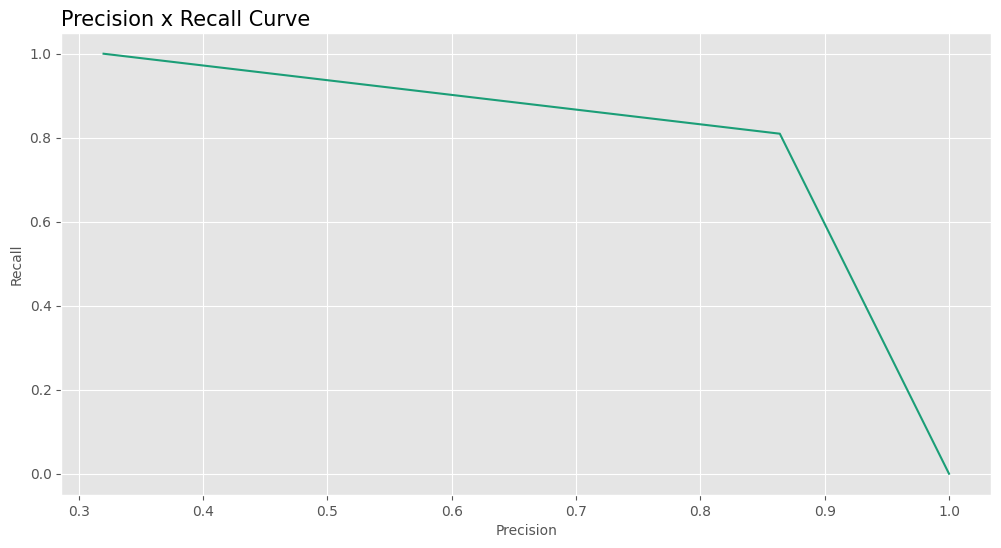

In [59]:
precision, recall, thres = metrics.precision_recall_curve(y_test, y_pred)

fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(x = precision, y = recall)
ax.set_title("Precision x Recall Curve", fontsize = 15, pad = 5, loc = 'left')
ax.set_xlabel("Precision", fontsize = 10)
ax.set_ylabel("Recall", fontsize = 10)
plt.show()

In [60]:
curve = metrics.roc_curve(y_test, y_proba)

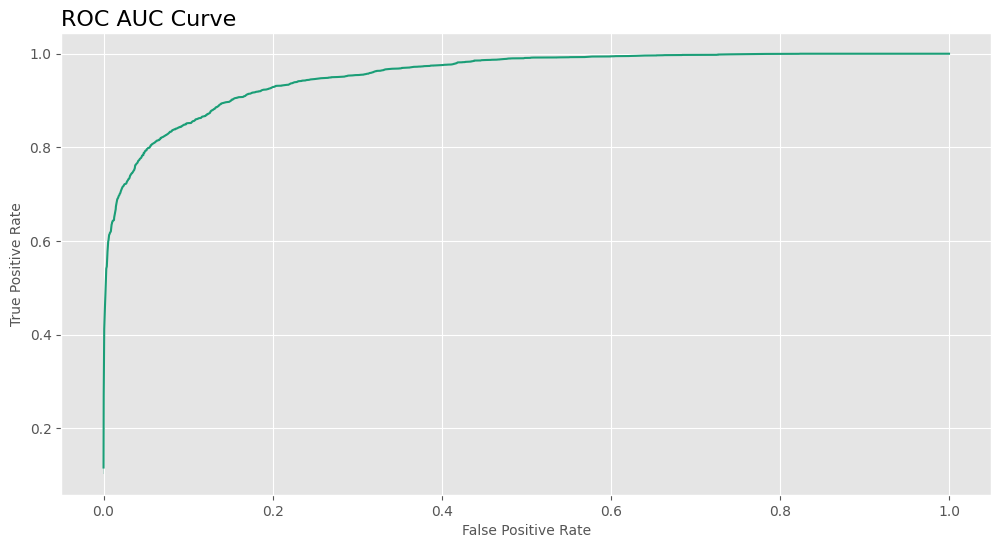

In [62]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(x = curve[0], y = curve[1])
ax.set_title(f"ROC AUC Curve", fontsize = 16, pad = 5, loc = 'left')
ax.set_xlabel("False Positive Rate", fontsize = 10)
ax.set_ylabel("True Positive Rate", fontsize = 10)
plt.show()

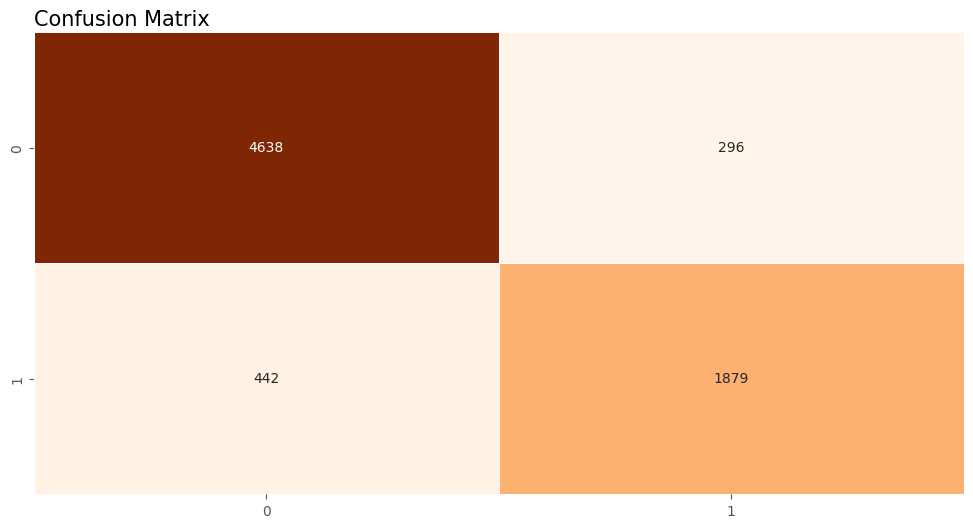

In [73]:
cf = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(cf, annot = True, fmt = 'd', linewidths=0.5, cmap = 'Oranges', cbar = False)
ax.set_title("Confusion Matrix", fontsize = 15, pad = 5, loc = 'left')
plt.show()

# Conclusions

### Some insights

- Reservations with long lead times need to be closely tracked. Simple actions like periodic confirmation messages or emails can be a good plan, as we've seen that the probability of cancellation starts to rise with longer lead times.
- A higher number of children increases the probability of cancellation, so this is also something to keep track of.
- Room Type 1 is the most popular, while Room Type 6 has the highest number of cancellations.
- The Online segment is the most popular and also has the highest cancellation rate. The Complementary and Corporate segments have the lowest cancellation rates, so it may be a good idea to reward them.

### About the model
The model achieved a good balance between precision and recall, as our main metric was the F1 Score. It demonstrated good generalization ability and strong metric results. To achieve a higher F1 Score, we can use a 0.6 threshold.